<style>
{
  margin: 0;
  padding: 0;
  box-sizing: border-box;}
 
  body {
  margin-left: -24px;
  margin-top: 0;
  font-family: "Arial", sans-serif;
  width: 100%;
  height: 100vh;
  display: flex;
  flex-direction: column;
  justify-content: space-between;
  box-sizing: border-box;
}
  .title {
    text-align: center;
    font-size: 36px; 
    font-weight: bold;
    align-items: center;
    margin-top: 50px; 
  }
  .subtitle {
    text-align: center;
    font-size: 28px; 
    font-weight: bold;
    align-items: center;
    margin-bottom: 30px;
  }
  .logo {
    text-align: center;
    margin: 50px 0; 
    align-items: center;
  }
  .project-title {
    text-align: center;
    font-size: 28px; 
    font-weight: bold;
    align-items: center;
    margin: 40px 0; 
  }
  .authors {
    font-size: 20px; 
    text-align: center;
    margin-bottom: 50px;
    align-items: center;
  }
</style>
 
<div class="title">POLITECHNIKA LUBELSKA</div>
<div class="subtitle">WYDZIAŁ MATEMATYKI I INFORMATYKI TECHNICZNEJ</div>
<div class="subtitle">Kierunek: Inżynieria i Analiza Danych</div>
 
<div class="logo">
<img src="logopl.png" alt="Logo Politechniki Lubelskiej" width="300"> <!-- Większe logo -->
</div>
 
<div class="project-title">Projekt Zaliczeniowy <br> Eksploracja danych</div>
<div class="subtitle"><em>Praca wykonana przez:</em></div>
<div class="authors">
<strong>Bartosz Oleszek, Nr albumu: 100996</strong> <br>
<strong>Szymon Chruśliński, Nr albumu: 100961</strong> <br>

</div>

## Wybór zbioru danych

W projekcie wykorzystano zbiór danych **Online Shoppers Purchasing Intention Dataset**, dostępny publicznie w repozytorium UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

Zbiór danych dotyczy zachowań użytkowników odwiedzających stronę e-commerce i zawiera informacje na temat sesji, aktywności użytkowników oraz właściwości samej strony. Obejmuje 12 330 rekordów reprezentujących indywidualne sesje oraz 18 zróżnicowanych zmiennych – zarówno numerycznych, jak i kategorycznych oraz logicznych. Dane te mogą posłużyć do budowy modeli predykcyjnych umożliwiających prognozowanie, czy dana sesja zakończy się dokonaniem zakupu.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import shapiro, anderson, mannwhitneyu, chi2_contingency
from statsmodels.stats.diagnostic import lilliefors
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import joblib

In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Zdefiniowanie problemu predykcyjnego oraz scharakteryzowanie analizowanego zbioru danych

Celem projektu jest zbudowanie i porównanie różnych modeli klasyfikacyjnych w celu znalezienia najlepszego rozwiązania do **przewidywania, czy sesja użytkownika zakończy się zakupem**, na podstawie danych dotyczących aktywności użytkownika na stronie e-commerce. Zmienną docelową jest `Revenue` - zmienna wskazuje, czy użytkownik zakończył sesję transakcją:

- `True` – zakup został dokonany
- `False` – brak zakupu

Problem ten ma charakter **binarny (klasyfikacja True/False)** i jest istotny z punktu widzenia biznesowego, ponieważ umożliwia przewidywanie konwersji oraz optymalizację działań marketingowych i UX (User Experience).

## Opis zmiennych w zbiorze danych

### Dane o aktywności użytkownika

`Administrative` - liczba odwiedzonych stron administracyjnych w danej sesji

`Administrative_Duration` - łączny czas spędzony na stronach administracyjnych (w sekundach)

`Informational` - liczba odwiedzonych stron informacyjnych w danej sesji

`Informational_Duration` - łączny czas spędzony na stronach informacyjnych (w sekundach)

`ProductRelated` - liczba odwiedzonych stron związanych z produktami w danej sesji

`ProductRelated_Duration` - łączny czas spędzony na stronach związanych z produktami (w sekundach)

### Dane behawioralne

`BounceRates` - odsetek sesji, w których użytkownik opuścił stronę bez interakcji (wartość od 0 do 1)

`ExitRates` - odsetek sesji, w których dana strona była ostatnią odwiedzoną (wartość od 0 do 1)

`PageValues` - średnia wartość przypisana stronie, bazująca na transakcjach dokonanych po jej odwiedzeniu

`SpecialDay` - wskaźnik bliskości sesji do specjalnego dnia zakupowego (np. Walentynki), wartość od 0 do 1, gdzie 1 oznacza największe prawdopodobieństwo transakcji

### Cechy techniczne i demograficzne

`Month` - miesiąc, w którym miała miejsce sesja (np. "Feb", "Mar")

`OperatingSystems` - identyfikator systemu operacyjnego używanego przez użytkownika

`Browser` - identyfikator przeglądarki internetowej używanej przez użytkownika

`Region` - identyfikator regionu geograficznego użytkownika

`TrafficType` - identyfikator typu źródła ruchu

`VisitorType` - typ odwiedzającego:

- Returning_Visitor
- New_Visitor
- Other

`Weekend` - wartość logiczna wskazująca, czy sesja miała miejsce w weekend (True lub False)

### Wynik sesji zakupowej

`Revenue` – wartość logiczna wskazująca, czy sesja zakończyła się transakcją (True) czy nie (False)

## Usuwanie duplikatów

In [4]:
duplicates = df.duplicated()
duplicates_number = duplicates.sum()

In [5]:
print("Liczba wierszy przed usunięciem duplikatów:", len(df))
print("Liczba zduplikowanych wierszy:", duplicates_number)
df = df.drop_duplicates()
print("Liczba wierszy po usunięciu duplikatów:", len(df))

Liczba wierszy przed usunięciem duplikatów: 12330
Liczba zduplikowanych wierszy: 125
Liczba wierszy po usunięciu duplikatów: 12205


## Sprawdzenie braków danych występujących w zbiorze

In [6]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Wszystkie kolumny są kompletne i nie wymagają imputacji braków.

## Kodowanie zmiennych kategorycznych

In [7]:
categorical_columns = ['Month', 'OperatingSystems', 'Browser', 'Region',
                       'TrafficType', 'VisitorType', 'Weekend', 'Revenue']

df[categorical_columns] = df[categorical_columns].astype('category')

## Rozkład liczby obserwacji w poszczególnych klasach

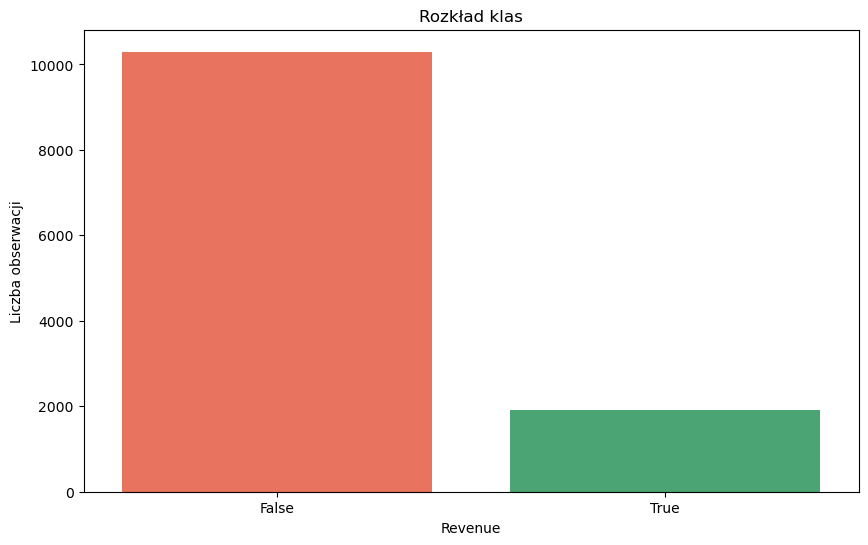

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Revenue', hue='Revenue', palette={False: 'tomato', True: 'mediumseagreen'}, legend=False)
plt.title('Rozkład klas')
plt.xlabel('Revenue')
plt.ylabel('Liczba obserwacji')
plt.show()

Zbiór danych jest niezbalansowany – 10297 obserwacji (84.4%) należy do klasy False, a 1908 (15.6%) do klasy True.

## Wartości odstające

In [9]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


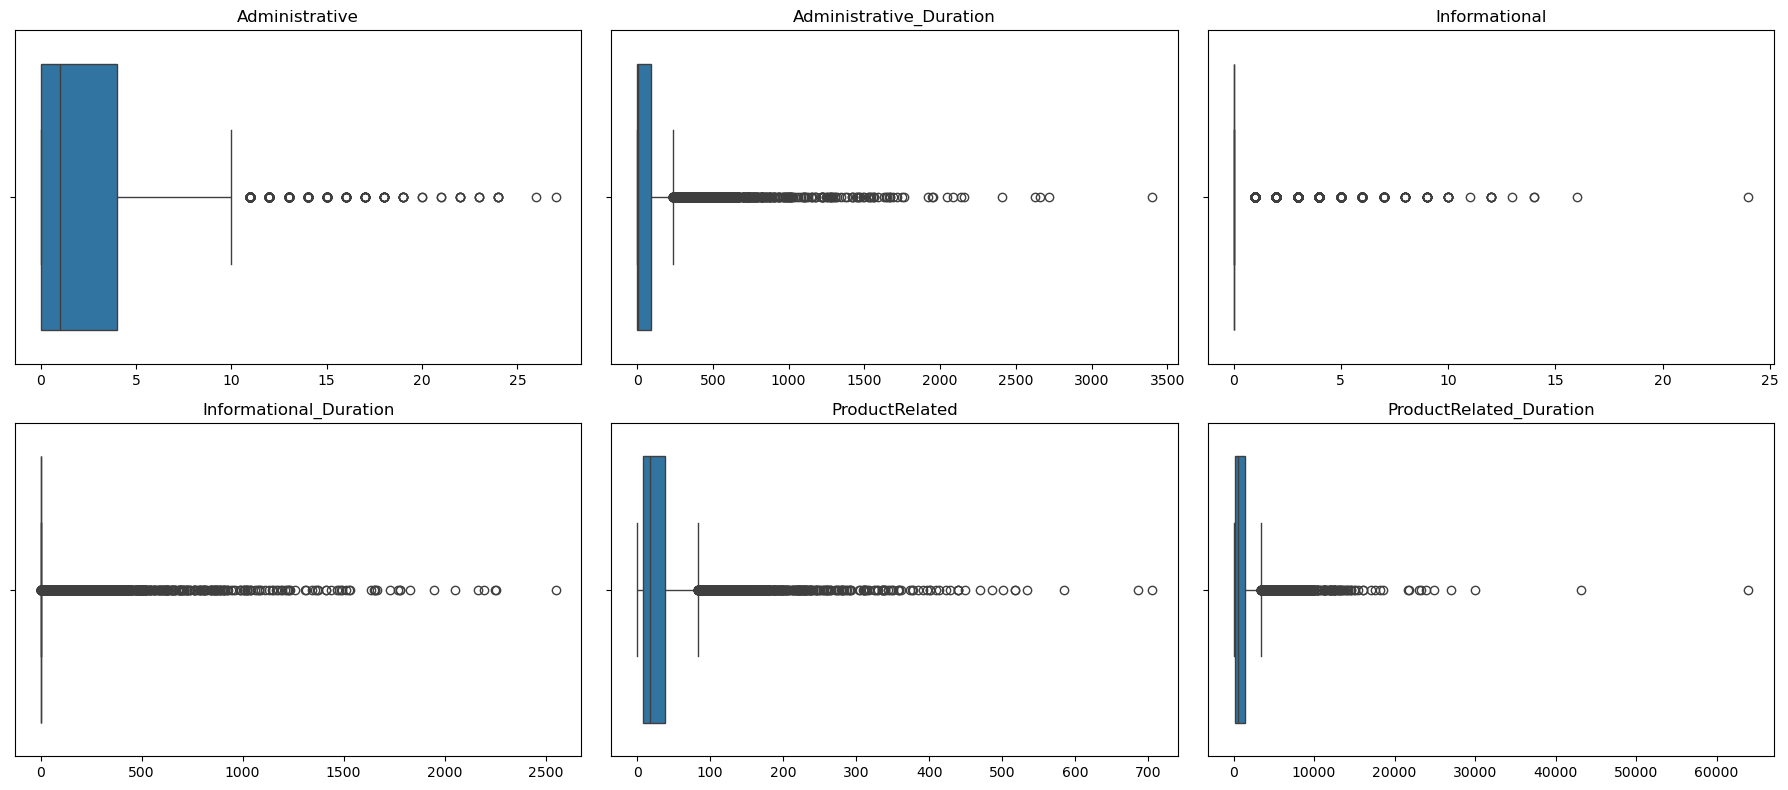

In [10]:
selected_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

axes = axes.flatten()

for i, column in enumerate(selected_columns):
    sns.boxplot(x=df[column], ax=axes[i], orient='h')
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

Na boxplotach dla zmiennych związanych z liczbą odwiedzin i czasem spędzonym na stronach widoczne są liczne i bardzo skrajne outliery. Szczególnie zmienne czasowe zawierają wartości sięgające nawet kilkudziesięciu tysięcy sekund (np. `ProductRelated_Duration` ponad 60 000 s, czyli ~17 godzin), co znacząco odbiega od typowych wartości.

Tak długie sesje mogą wskazywać na:

- zostawienie otwartej strony na długo bez aktywności
- działanie botów
- nietypowe zachowania użytkowników (np. wielokrotne przeglądanie wielu produktów)

Warto rozważyć obsługę tych outlierów przed dalszą analizą, ponieważ pozostawienie ich bez przekształcenia może zaburzać modele i analizy statystyczne.

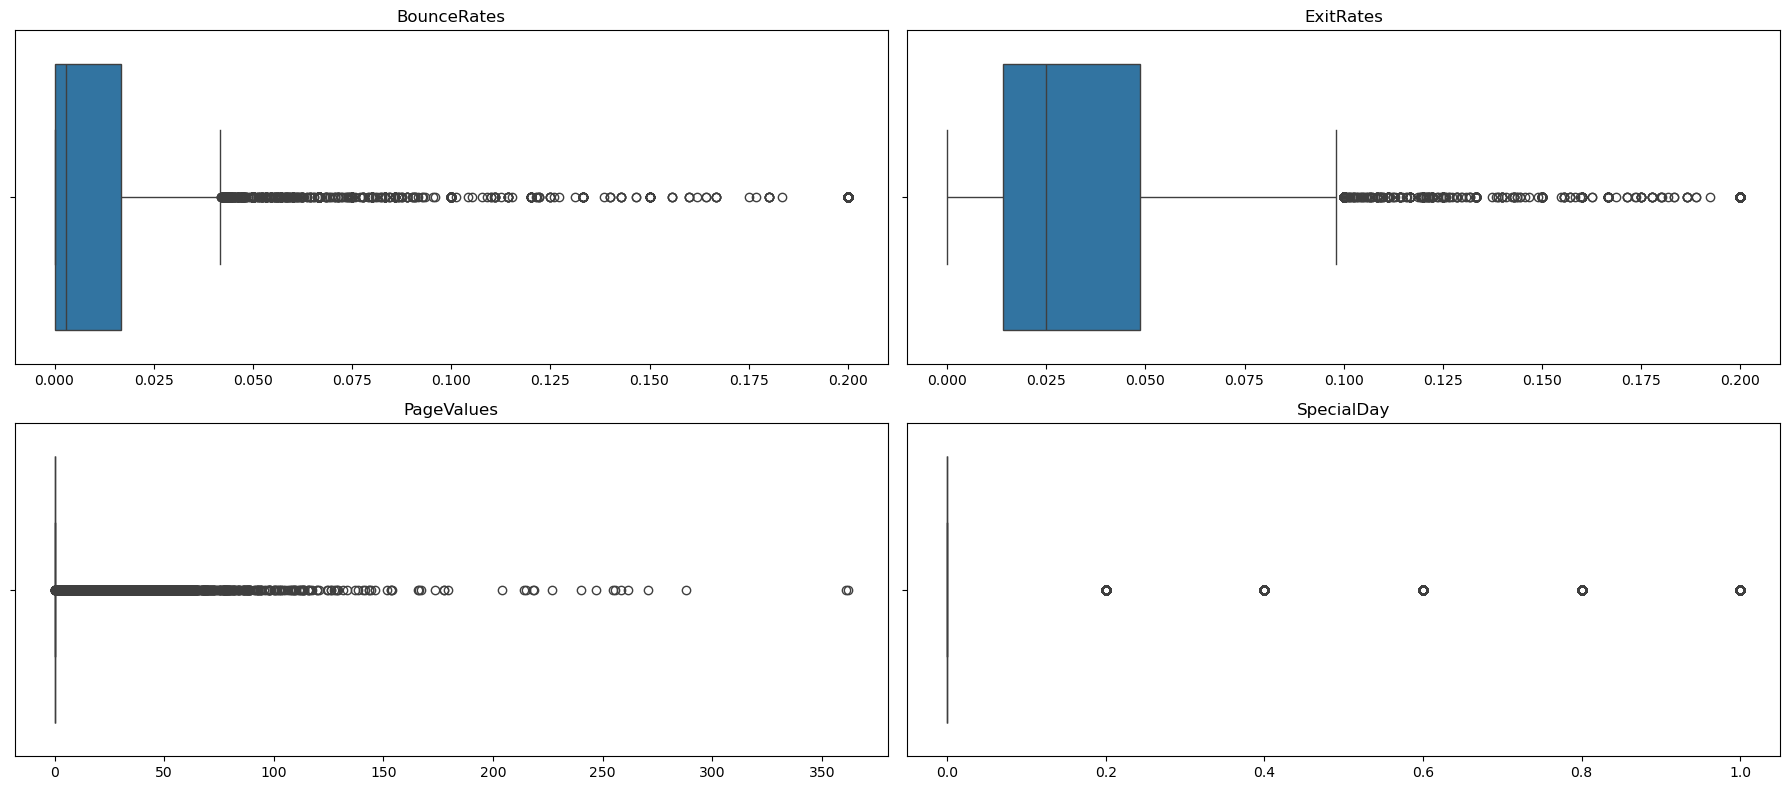

In [11]:
selected_columns = ['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

fig, axes = plt.subplots(2, 2, figsize=(18, 8))

axes = axes.flatten()

for i, column in enumerate(selected_columns):
    sns.boxplot(x=df[column], ax=axes[i], orient='h')
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

Na boxplotach widać potencjalne outliery dla zmiennych `BounceRates`, `ExitRates`, `SpecialDay` i `PageValues`, jednak statystyki opisowe pokazują, że wartości dla pierwszych trzech mieszczą się w zakresie [0, 1], co jest zgodne z ich naturą jako wskaźników – nie są to więc rzeczywiste odstępstwa. W przypadku `PageValues` wyższe wartości (nawet > 300) są również uzasadnione, ponieważ odzwierciedlają potencjalną wartość przychodową sesji. W związku z tym nie ma podstaw, by uznawać te wartości za błędne lub wymagające usunięcia.

## Podział na zbiór treningowy, walidacyjny i testowy

In [12]:
# X_temp i y_temp to tymczasowe zbiory, które posłużą do utworzenia zbioru walidacyjnego i testowego

X = df.drop("Revenue", axis=1)
y = df["Revenue"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

In [13]:
X_train.shape, X_val.shape, X_test.shape

((8543, 17), (1831, 17), (1831, 17))

Aby uniknąć przecieku danych i zapewnić obiektywną ocenę modeli, dane zostały podzielone na zbiór treningowy (70%), walidacyjny (15%) i testowy (15%). Podział został wykonany losowo, z zachowaniem proporcji klas zmiennej docelowej `Revenue`. Ponieważ zbiór danych jest niezbalansowany klasowo, zastosowano **losowanie warstwowe (stratify)**, aby każda część danych wiernie odzwierciedlała rozkład klas. 

## Grupowanie rzadkich kategorii w zmiennych kategorycznych

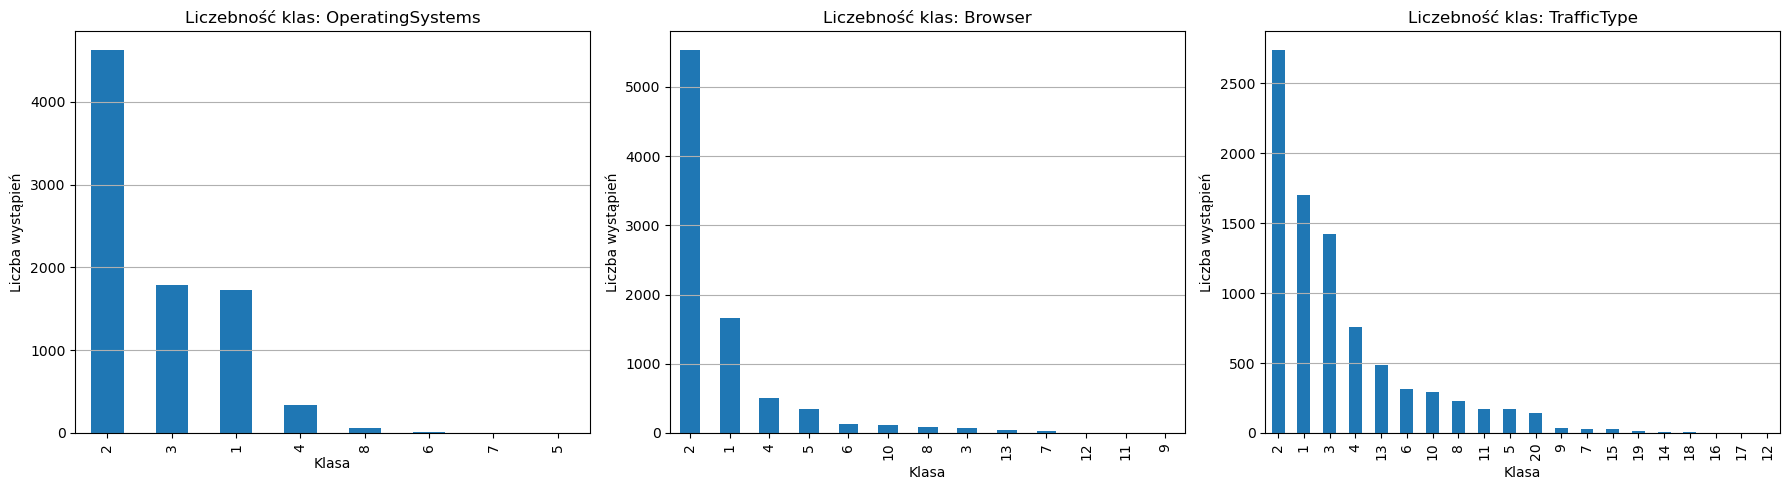

In [14]:
cols = ['OperatingSystems', 'Browser', 'TrafficType']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(cols):
    counts = X_train[col].value_counts().sort_values(ascending=False)
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Liczebność klas: {col}')
    axes[i].set_ylabel('Liczba wystąpień')
    axes[i].set_xlabel('Klasa')
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()

In [15]:
rare_thresholds = {
    'OperatingSystems': 200,
    'Browser': 100,
    'TrafficType': 200
}

for col, threshold in rare_thresholds.items():
    rare_labels = X_train[col].value_counts()[lambda x: x < threshold].index

    for split in [X_train, X_val, X_test]:
        split[col] = split[col].apply(lambda x: 'Other' if x in rare_labels else str(x))

W celu poprawy jakości i stabilności modelu przeprowadzono grupowanie rzadko występujących kategorii w zmiennych kategorycznych. Klasy o liczności poniżej ustalonych progów zostały zastąpione wspólną etykietą „Other”, co ograniczyło ryzyko nadmiernego dopasowania oraz uprościło późniejsze kodowanie zmiennych.

## Obsługa outlierów

In [16]:
def winsorize_column_upper_only(series, upper):
    mask = series > upper
    return series.clip(upper=upper), mask

duration_columns = [
    "Administrative",
    "Administrative_Duration",
    "Informational",
    "Informational_Duration",
    "ProductRelated",
    "ProductRelated_Duration"
]

counters = {
    "X_train": 0,
    "X_val": 0,
    "X_test": 0
}

for col in duration_columns:
    upper = X_train[col].quantile(0.98)

    for X, name in zip([X_train, X_val, X_test], ["X_train", "X_val", "X_test"]):
        X[col], mask = winsorize_column_upper_only(X[col], upper)
        counters[name] += mask.sum()

for name in counters:
    print(f"{name}: przycięto łącznie {counters[name]} wartości")

X_train: przycięto łącznie 954 wartości
X_val: przycięto łącznie 161 wartości
X_test: przycięto łącznie 220 wartości


Początkowo zastosowano metodę IQR do usuwania outlierów, jednak prowadziła ona do odrzucenia nawet 30% obserwacji, co skutkowało znaczną utratą informacji. W związku z tym zdecydowano się na łagodniejsze podejście – winsoryzację jedynie od góry. Dla każdej zmiennej liczbowej wartości powyżej 98. percentyla (wyznaczanego na zbiorze treningowym) zostały obcięte do wartości progowej, natomiast wartości niższe pozostawiono bez zmian. Takie rozwiązanie pozwoliło ograniczyć wpływ ekstremalnych obserwacji, zachowując jednocześnie pełny zbiór danych.

## Wstępna selekcja cech o niskiej zmienności

In [17]:
X_train_num = X_train.select_dtypes(include=[np.number])
X_train_cat = X_train.select_dtypes(include=['category'])

var_num = X_train_num.var()
low_var_num_cols = var_num[var_num < 1e-5].index.tolist()

prop_cat = X_train_cat.apply(lambda x: x.value_counts(normalize=True).max())
low_var_cat_cols = prop_cat[prop_cat > 0.95].index.tolist()

low_variance_cols = low_var_num_cols + low_var_cat_cols

print("Cechy o niskiej zmienności:")
print(low_variance_cols)

Cechy o niskiej zmienności:
[]


Przeprowadzono wstępną selekcję cech na podstawie zmienności. Zmienna była uznawana za mało informacyjną, jeśli jej wariancja była bliska zeru (dla danych liczbowych) lub jeśli jedna z kategorii występowała w ponad 95% przypadków (dla danych kategorycznych). W analizowanym zbiorze nie wykryto zmiennych spełniających te kryteria.

## Sprawdzenie współliniowości zmiennych liczbowych

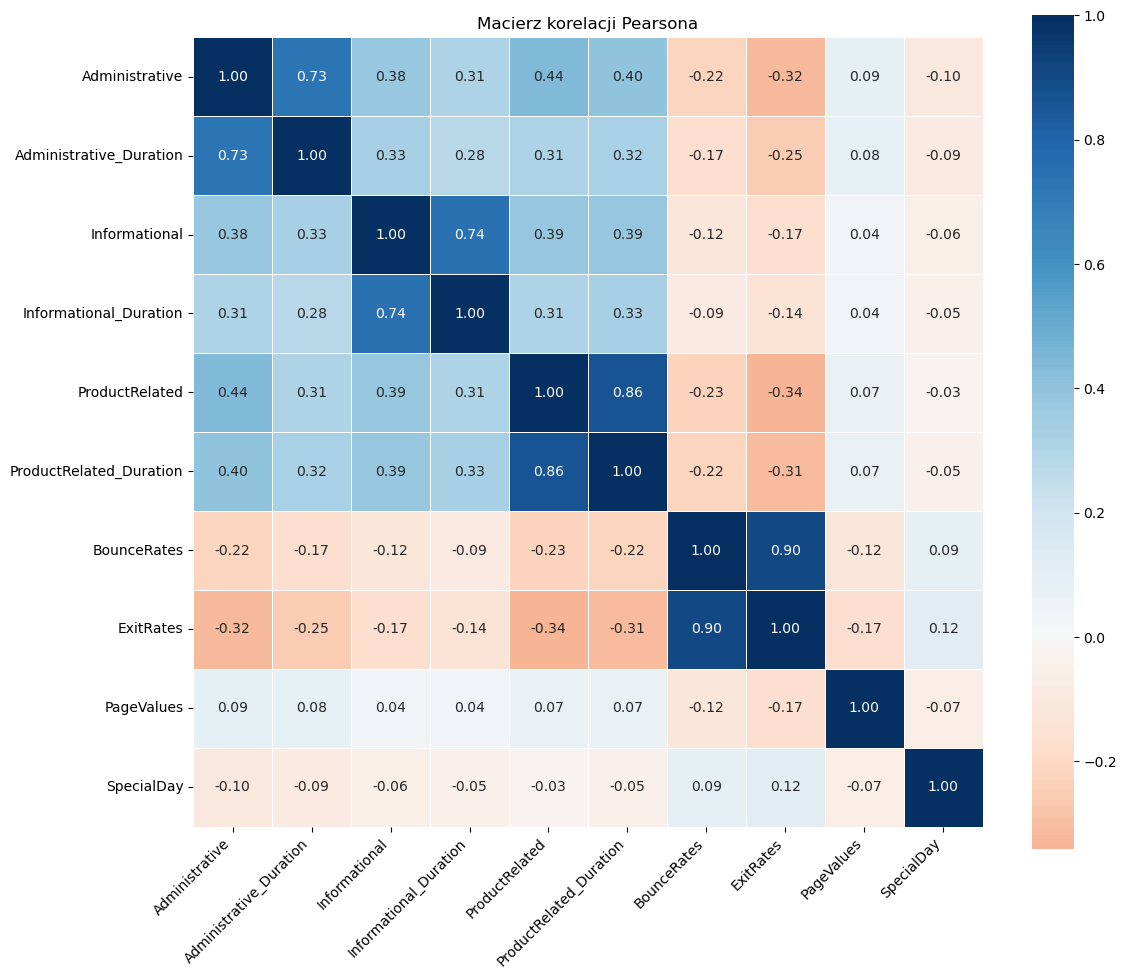

In [18]:
cor_matrix_df = X_train_num.corr(method='pearson')

cor_matrix_df = cor_matrix_df.round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cor_matrix_df,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0,
    linewidths=0.5,
    square=True
)
plt.title("Macierz korelacji Pearsona")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
cols_to_drop = ['BounceRates', 'Administrative', 'Informational', 'ProductRelated']

X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

Ze zbioru danych usunięto cztery zmienne: `BounceRates`, `Administrative`, `Informational` oraz `ProductRelated`. Zmienna `BounceRates` została wykluczona z uwagi na bardzo wysoką korelację z `ExitRates` (r = 0.90). Pozostałe trzy zmienne (`Administrative`, `Informational`, `ProductRelated`) wykazywały silną korelację ze swoimi odpowiednikami czasowymi (`*_Duration`, r = 0.73–0.86), co wskazuje na dużą redundancję informacji. W związku z tym zostały usunięte, aby ograniczyć współliniowość i uprościć zbiór danych.

## Selekcja cech na podstawie Mutual Information

In [20]:
X_encoded = X_train.copy()

categorical_cols = X_encoded.select_dtypes(exclude='number').columns

encoder = OrdinalEncoder()
X_encoded[categorical_cols] = encoder.fit_transform(X_encoded[categorical_cols])
discrete_mask = [col in categorical_cols for col in X_encoded.columns]

mi_scores = mutual_info_classif(X_encoded, y_train, discrete_features=discrete_mask, random_state=42)

mi_scores_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

display(mi_scores_df)

,Feature,MI_Score
4,PageValues,0.166256
3,ExitRates,0.041453
2,ProductRelated_Duration,0.033039
6,Month,0.015128
10,TrafficType,0.014606
0,Administrative_Duration,0.014162
1,Informational_Duration,0.009462
5,SpecialDay,0.005899
11,VisitorType,0.004199
7,OperatingSystems,0.003446


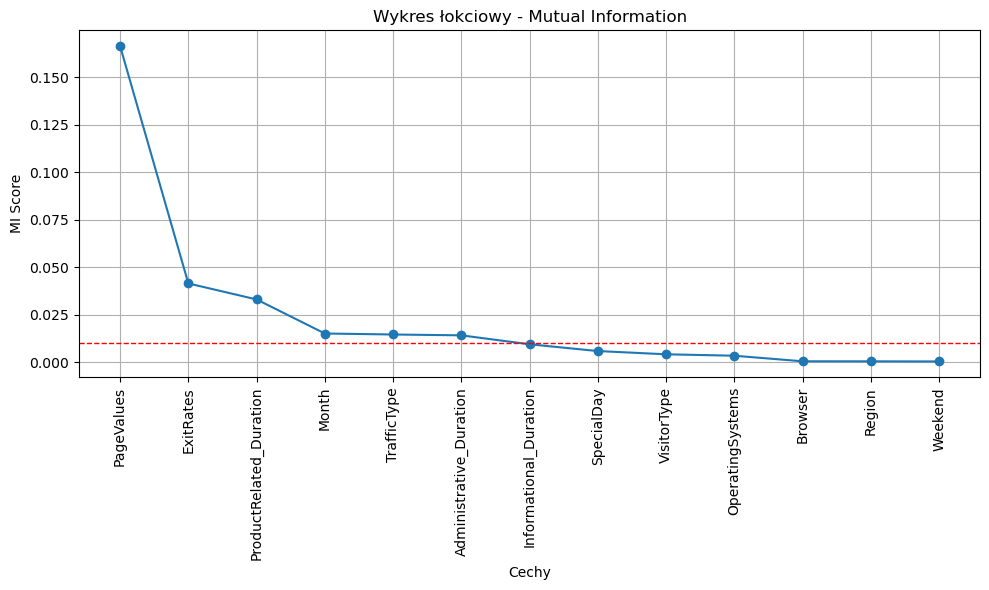

In [21]:
mi_scores_values = mi_scores_df['MI_Score'].values
features = mi_scores_df['Feature'].values

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mi_scores_values) + 1), mi_scores_values, marker='o')
plt.xticks(ticks=range(1, len(features) + 1), labels=features, rotation=90)

plt.axhline(y=0.01, color='red', linestyle='--', linewidth=1)

plt.title('Wykres łokciowy - Mutual Information')
plt.xlabel('Cechy')
plt.ylabel('MI Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Na podstawie uzyskanych wyników Mutual Information oraz wykresu łokciowego można zauważyć wyraźny spadek wartości informacyjnej po pierwszej cesze - `PageValues`, dla której wartość MI wynosi odpowiednio 0.1663. Oznacza to, że cecha ta ma istotny wpływ na przewidywanie zmiennej `Revenue`.

Wartość Mutual Information dla kolejnych cech spada stopniowo (choć nadal powyżej przyjętego progu 0.01), co sugeruje ich ograniczony, ale niezerowy wkład w model predykcyjny. Z tego względu, do dalszej analizy wybrano sześć cech przekraczających ustalony próg istotności MI > 0.01.

In [22]:
selected_features = mi_scores_df['Feature'].head(6).tolist()
print("Wybrane cechy:", selected_features)

Wybrane cechy: ['PageValues', 'ExitRates', 'ProductRelated_Duration', 'Month', 'TrafficType', 'Administrative_Duration']


W kolejnym kroku cechy te zostaną poddane analizie zależności względem zmiennej `Revenue`, zarówno wizualnie, jak i statystycznie. Pozwoli to ocenić, które z nich faktycznie rozróżniają klasy oraz czy warto ograniczyć model do mniejszej liczby predyktorów o silniejszym wpływie, czy też zachować pełny zestaw cech.

In [23]:
X_train = X_train[selected_features].copy()
X_val = X_val[selected_features].copy()
X_test = X_test[selected_features].copy()

## Analiza zależności między zmiennymi numerycznymi a wynikiem sesji zakupowej

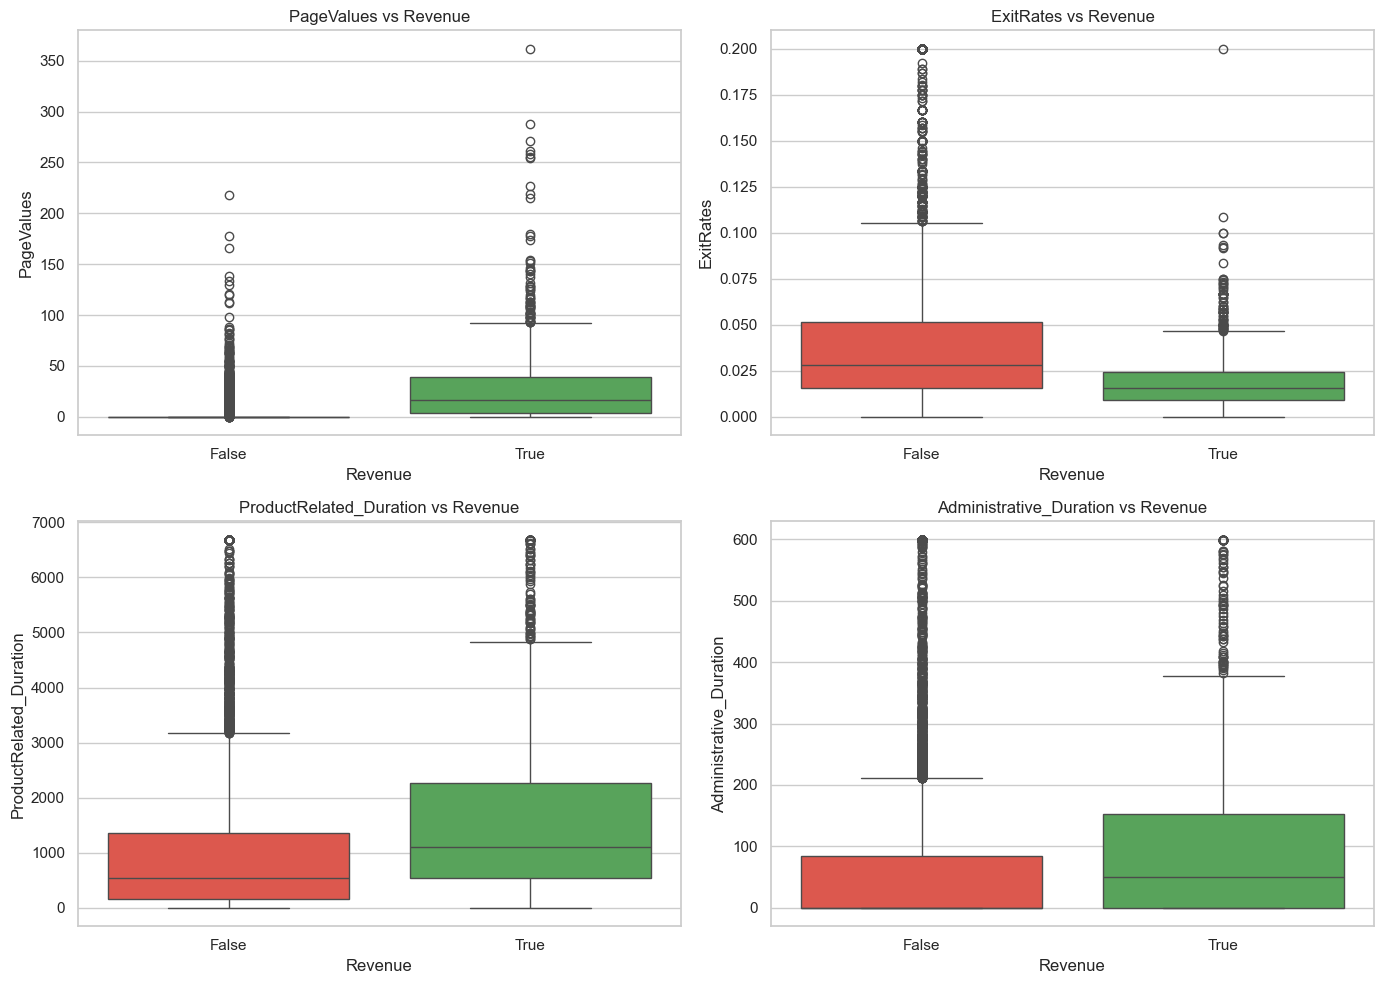

In [24]:
# X_train_plot jest definiowane dlatego, że sns wymaga ramki danych ze zmienną zależną `Revenue`.
X_train_plot = X_train.copy()
X_train_plot["Revenue"] = y_train

# Lista zmiennych numerycznych
numeric_features = ['PageValues', 'ExitRates', 'ProductRelated_Duration', 'Administrative_Duration']

# Ustawienia stylu
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))
palette_colors = {True: "#4CAF50", False: "#F44336"}

# Tworzenie boxplotów na podstawie X_train_plot (a nie df!)
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=X_train_plot, x="Revenue", y=feature, hue="Revenue",
                palette=palette_colors, dodge=False, legend=False)
    plt.title(f'{feature} vs Revenue')

plt.tight_layout()
plt.show()

- `PageValues` - widocznie wyższe wartości dla sesji zakończonych zakupem – sugeruje silny związek z `Revenue`.
- `ExitRates` - widocznie niższe w przypadku zakupów – przypuszczamy, że zmienna ta istotnie różnicuje zmienną zależną.
- `ProductRelated_Duration` - osoby dokonujące zakupu spędzają widocznie więcej czasu na stronach produktowych.
- `Administrative_Duration` - również nieco wyższe w sesjach zakończonych zakupem, ale różnica wizualnie mniejsza niż w przypadku `PageValues`.

Można zatem przypuszczać, że zmienne `PageValues`, `ExitRates`, `ProductRelated_Duration` oraz `Administrative_Duration` mają istotny wpływ na zmienną zależną `Revenue`. Zostanie to sprawdzone statystycznie zaczynając od testu normalności, a następnie testu t-Studenta lub Manna-Whitneya.

In [25]:
for feature in numeric_features:
    group_true = X_train[y_train == True][feature]
    group_false = X_train[y_train == False][feature]

    stat_true, pval_true = shapiro(group_true.sample(500, random_state=1))  # próbka, bo ograniczenie 5000 w Shapiro
    stat_false, pval_false = shapiro(group_false.sample(500, random_state=1))

    print(f"{feature}:")
    print(f"  Revenue = True:  stat = {stat_true:.4f}, p = {pval_true:.4f}")
    print(f"  Revenue = False: stat = {stat_false:.4f}, p = {pval_false:.4f}\n")

PageValues:
  Revenue = True:  stat = 0.7302, p = 0.0000
  Revenue = False: stat = 0.2263, p = 0.0000

ExitRates:
  Revenue = True:  stat = 0.8736, p = 0.0000
  Revenue = False: stat = 0.7150, p = 0.0000

ProductRelated_Duration:
  Revenue = True:  stat = 0.7939, p = 0.0000
  Revenue = False: stat = 0.7447, p = 0.0000

Administrative_Duration:
  Revenue = True:  stat = 0.7305, p = 0.0000
  Revenue = False: stat = 0.5670, p = 0.0000



Dla wszystkich analizowanych zmiennych (`PageValues`, `ExitRates`, `ProductRelated_Duration`, `Administrative_Duration`) otrzymano p-value < 0.05 zarówno dla grupy `Revenue = True`, jak i `Revenue = False`, zatem odrzucamy hipotezę o normalności rozkładu we wszystkich przypadkach.  Zamiast testu t-Studenta zastosujemy nieparametryczny test Manna-Whitneya, który nie zakłada normalności.

In [26]:
for feature in numeric_features:
    group_true = X_train[y_train == True][feature]
    group_false = X_train[y_train == False][feature]

    stat, pval = mannwhitneyu(group_true, group_false, alternative='two-sided')

    print(f" {feature} | Revenue: p = {pval:.4f}")

 PageValues | Revenue: p = 0.0000
 ExitRates | Revenue: p = 0.0000
 ProductRelated_Duration | Revenue: p = 0.0000
 Administrative_Duration | Revenue: p = 0.0000


Dla wszystkich zmiennych numerycznych przeprowadzono test nieparametryczny Manna-Whitneya w celu porównania rozkładów tych cech pomiędzy grupami:
`Revenue = True` (zakup) oraz `Revenue = False` (brak zakupu).
W każdym przypadku uzyskano wartość p < 0.05, co oznacza, że:
**Istnieją statystycznie istotne różnice w rozkładach tych cech między sesjami zakończonymi zakupem a tymi bez zakupu**.

## Analiza zależności między zmiennymi kategorycznymi a wynikiem sesji zakupowej

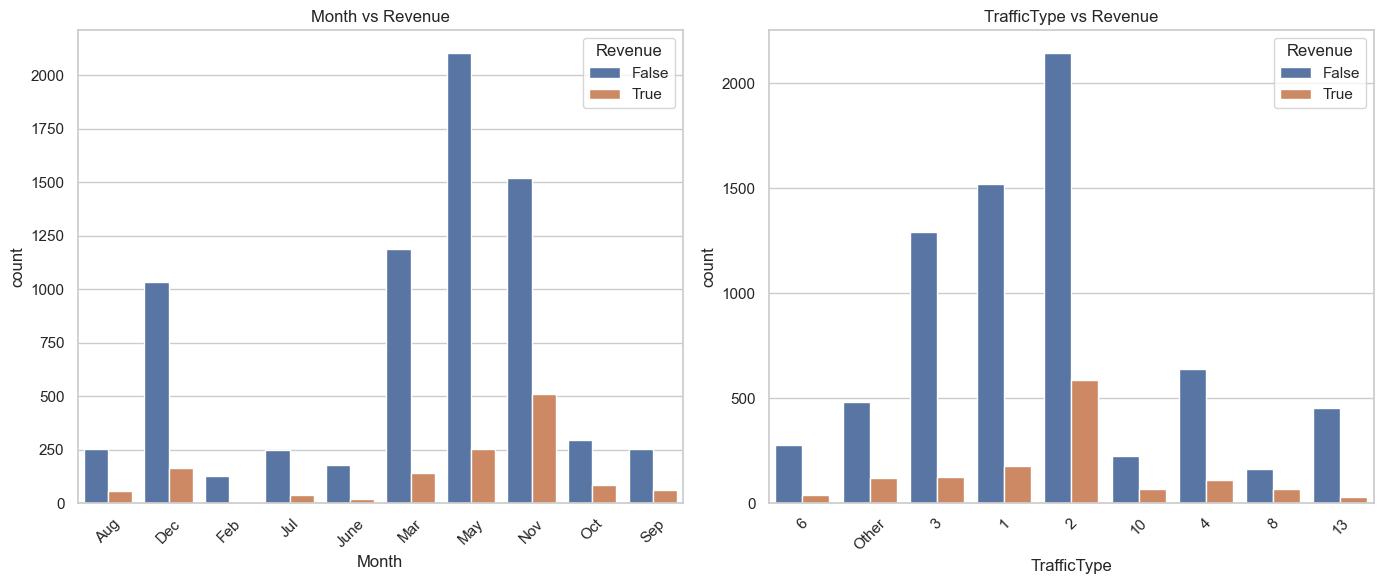

In [27]:
categorical_features = ['Month', 'TrafficType']

plt.figure(figsize=(14, 6))

for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i + 1)
    sns.countplot(data=X_train_plot, x=feature, hue="Revenue")
    plt.title(f'{feature} vs Revenue')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

-  zauważalne są większe odsetki zakupów w listopadzie i maju porównując z pozostałymi miesiącami
- najwięcej transakcji pochodzi z typu 2 oraz 1 - może to wskazywać na skuteczniejsze kanały marketingowe.

Można zatem przypuszcza, że zmienne `Month` i `TrafficType` mają istotny wpływ na decyzję o dokonaniu zakupu. Zostanie to zweryfikowane testem niezależności chi-kwadrat.

In [28]:
for feature in categorical_features:
    contingency = pd.crosstab(X_train_plot[feature], X_train_plot["Revenue"])
    chi2, p, dof, expected = chi2_contingency(contingency)

    print(f"{feature} | Revenue:")
    print(f" p = {p:.4e}")

Month | Revenue:
 p = 1.0978e-50
TrafficType | Revenue:
 p = 2.3464e-48


Dla obu analizowanych zmiennych kategorycznych otrzymano bardzo niskie wartości p (p < 0.05) w teście niezależności chi-kwadrat. Oznacza to, że **istnieje statystycznie istotna zależność** między zmienną `Revenue` a zmiennymi `Month` i `TrafficType`. W związku z tym odrzucamy hipotezę o niezależności. Można więc przypuszczać, że miesiąc, w którym miała miejsce sesja, oraz źródło ruchu użytkownika wpływają na decyzję o dokonaniu zakupu.

## Ostateczny wniosek - wybór cech do dalszego modelowania

Na podstawie przeprowadzonych testów statystycznych wykazano, że wszystkie sześć cech wybranych wcześniej na podstawie Mutual Information:

- `PageValues`
- `ExitRates`
- `ProductRelated_Duration`
- `Administrative_Duration`
- `Month`
- `TrafficType`

**są statystycznie istotnie zróżnicowane względem zmiennej docelowej** `Revenue`.
W związku z tym **wszystkie te cechy zostaną uwzględnione w dalszym etapie trenowania modeli klasyfikacyjnych**.

## Standaryzacja zmiennych numerycznych

In [29]:
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_val_scaled = scaler.transform(X_val[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_final = pd.concat([
    pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index),
    X_train.drop(columns=num_cols)
], axis=1)

X_val_final = pd.concat([
    pd.DataFrame(X_val_scaled, columns=num_cols, index=X_val.index),
    X_val.drop(columns=num_cols)
], axis=1)

X_test_final = pd.concat([
    pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index),
    X_test.drop(columns=num_cols)
], axis=1)

Zmiennym numerycznym nadano standaryzowaną postać za pomocą transformatora `StandardScaler`, przekształcającego dane do rozkładu o średniej 0 i odchyleniu standardowym 1.

Parametry skalowania (średnia i odchylenie) wyznaczono wyłącznie na zbiorze treningowym, a następnie zastosowano je do zbiorów walidacyjnego i testowego. Pozwoliło to uniknąć zjawiska przecieku danych (data leakage).

## Kodowanie one-hot zmiennych kategorycznych

In [30]:
X_train_final = pd.get_dummies(X_train_final, columns=['Month', 'TrafficType'], drop_first=True, dtype=int)
X_val_final = pd.get_dummies(X_val_final, columns=['Month', 'TrafficType'], drop_first=True, dtype=int)
X_test_final = pd.get_dummies(X_test_final, columns=['Month', 'TrafficType'], drop_first=True, dtype=int)

Zmiennym kategorycznym przypisano reprezentację numeryczną za pomocą kodowania one-hot. W ramach tej transformacji każda kategoria została przekształcona w osobną kolumnę binarną (0/1), przy czym zastosowano parametr `drop_first=True`, aby uniknąć kolinearności.

Kodowanie przeprowadzono osobno dla zbiorów treningowego, walidacyjnego oraz testowego, z zachowaniem tych samych kategorii. Typ danych kolumn wynikowych został jawnie ustawiony jako `int`, co zapewnia pełną kompatybilność z algorytmami uczenia maszynowego.

In [31]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

Zmienna docelowa `Revenue`, pierwotnie zapisana jako wartość logiczna (True/False), została przekształcona na format numeryczny (0/1):
`False = 0`, `True = 1`.
Taka postać zmiennej jest wymagana przez większość algorytmów klasyfikacyjnych, które oczekują etykiet w postaci liczb całkowitych.

## Balansowanie klas w zbiorze treningowym

In [32]:
samplers = {
    "random_oversampling": RandomOverSampler(random_state=42),
    "smote": SMOTE(random_state=42),
    "adasyn": ADASYN(random_state=42),
    "random_undersampling": RandomUnderSampler(random_state=42)
}

X_train_smote, y_train_smote = samplers["smote"].fit_resample(X_train_final, y_train)
X_train_adasyn, y_train_adasyn = samplers["adasyn"].fit_resample(X_train_final, y_train)
X_train_over, y_train_over = samplers["random_oversampling"].fit_resample(X_train_final, y_train)
X_train_under, y_train_under = samplers["random_undersampling"].fit_resample(X_train_final, y_train)

print("Oryginalny zbiór (bez resamplingu):", y_train.value_counts().to_dict())
print("SMOTE:", y_train_smote.value_counts().to_dict())
print("ADASYN:", y_train_adasyn.value_counts().to_dict())
print("Random Oversampling:", y_train_over.value_counts().to_dict())
print("Random Undersampling:", y_train_under.value_counts().to_dict())

Oryginalny zbiór (bez resamplingu): {0: 7207, 1: 1336}
SMOTE: {0: 7207, 1: 7207}
ADASYN: {0: 7207, 1: 7203}
Random Oversampling: {0: 7207, 1: 7207}
Random Undersampling: {0: 1336, 1: 1336}


W związku z dużą nierównowagą klas w zbiorze danych (znaczna przewaga obserwacji z `Revenue = 0` nad `Revenue = 1`), zastosowano techniki balansowania klas wyłącznie na zbiorze treningowym. Celem było zwiększenie skuteczności klasyfikatorów w wykrywaniu przypadków zakończonych zakupem.

Wykorzystano następujące metody balansowania:

- **Random Oversampling** – losowe powielanie obserwacji klasy mniejszościowej do poziomu klasy większościowej
- **SMOTE (Synthetic Minority Over-sampling Technique)** – generowanie syntetycznych obserwacji klasy mniejszościowej na podstawie sąsiadów
- **ADASYN (Adaptive Synthetic Sampling)** – odmiana SMOTE ukierunkowana na trudniejsze przypadki
- **Random Undersampling** – losowe usunięcie obserwacji klasy większościowej, tak aby liczebność klas była równa

Dla każdej z wymienionych metod przygotowano osobne zbiory treningowe. Dane walidacyjne i testowe pozostały bez zmian, zgodnie z zasadą, że balansowanie stosuje się wyłącznie na etapie trenowania modeli.

## Porównanie modeli klasyfikacyjnych w zależności od metody balansowania danych

Każdy z przygotowanych zbalansowanych zbiorów zostanie wykorzystany do trenowania pięciu wybranych modeli klasyfikacyjnych:

- lasu losowego (Random Forest)
- regresji logistycznej
- maszyny wektorów nośnych (SVM)
- naiwnego klasyfikatora Bayesa
- modelu XGBoost

Dla każdego połączenia metody balansowania i modelu obliczone zostaną metryki klasyfikacji, a następnie wybrana zostanie najlepsza kombinacja.

In [33]:
datasets = {
    "Oryginalny": (X_train_final, y_train),
    "SMOTE": (X_train_smote, y_train_smote),
    "ADASYN": (X_train_adasyn, y_train_adasyn),
    "Random Oversampling": (X_train_over, y_train_over),
    "Random Undersampling": (X_train_under, y_train_under)
}

In [34]:
def test_balancing_methods(model, model_name, datasets, X_val_final, y_val):
    results = {model_name: {}}

    for name, (X_tr, y_tr) in datasets.items():
        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_pred = clf.predict(X_val_final)
        cm = confusion_matrix(y_val, y_pred)

        results[model_name][name] = {
            "F1-Score_Val": f1_score(y_val, y_pred, average="binary", zero_division=0),
            "Recall_Val": recall_score(y_val, y_pred, average="binary", zero_division=0),
            "Precision_Val": precision_score(y_val, y_pred, average="binary", zero_division=0),
            "Accuracy_Val": accuracy_score(y_val, y_pred),
            "Confusion_Matrix_Val": cm
        }

    return results

## Random Forest

In [35]:
model = RandomForestClassifier(random_state=42)
model_name = "Random Forest"

results_rf = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [36]:
df_results_rf = pd.DataFrame(results_rf["Random Forest"]).T
df_results_rf = df_results_rf.drop(columns=["Confusion_Matrix_Val"])
df_results_rf.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'Random Oversampling' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.617,0.556,0.694,0.892
SMOTE,0.648,0.766,0.562,0.870
ADASYN,0.631,0.773,0.534,0.859
Random Oversampling,0.660,0.675,0.645,0.891
Random Undersampling,0.626,0.867,0.490,0.838


W celu oceny wpływu różnych metod balansowania klas na skuteczność klasyfikatora Random Forest porównano pięć wariantów balansowania zbioru treningowego. Skuteczność oceniano na zbiorze walidacyjnym, wykorzystując cztery metryki: `F1-Score`, `Recall`, `Precision` oraz `Accuracy`.

Najlepsze rezultaty osiągnięto przy zastosowaniu metody **Random Oversampling**, która uzyskała najwyższe wartości w niemal wszystkich metrykach (`F1-Score` = 0.660, `Recall` = 0.675, `Precision` = 0.645, `Accuracy` = 0.891).

Na podstawie otrzymanych wyników można stwierdzić, że że dla modelu Random Forest najlepszą metodą balansowania klas okazał się **Random Oversampling**, który pozwolił uzyskać najwyższą skuteczność klasyfikacji przy zachowaniu równowagi pomiędzy precyzją a czułością.

## Regresja logistyczna

In [37]:
model = LogisticRegression(max_iter=1000)
model_name = "Logistic Regression"

results_lr = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [38]:
df_results_lr = pd.DataFrame(results_lr["Logistic Regression"]).T
df_results_lr = df_results_lr.drop(columns=["Confusion_Matrix_Val"])
df_results_lr.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'Random Undersampling' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.502,0.367,0.795,0.886
SMOTE,0.609,0.790,0.496,0.842
ADASYN,0.555,0.850,0.413,0.788
Random Oversampling,0.611,0.780,0.502,0.845
Random Undersampling,0.627,0.783,0.523,0.855


W przypadku regresji logistycznej najlepsze wyniki osiągnięto przy zastosowaniu metody **Random Undersampling**, która uzyskała najwyższe wartości w praktycznie wszystkich kluczowych metrykach: `F1-Score` = 0.627, `Recall` = 0.783, `Precision` = 0.523 oraz `Accuracy` = 0.855. Oznacza to, że mimo ograniczenia liczby przykładów z klasy dominującej, model był w stanie zachować dobrą równowagę między precyzją a czułością.

W przypadku pozostałych metod balansowania, takich jak SMOTE i Random Oversampling, uzyskano zbliżone, choć nieco słabsze rezultaty. Najsłabsze wyniki osiągnięto dla danych oryginalnych – pomimo wysokiej `Precision` (0.795), pozostałe metryki, w tym `Recall` (0.367), były wyraźnie niższe, co wskazuje na problem z wykrywaniem klasy mniejszościowej (czyli użytkowników dokonujących zakupu).

Na podstawie uzyskanych wyników można stwierdzić, że **dla modelu regresji logistycznej najlepszą metodą balansowania klas okazał się Random Undersampling**, który pozwolił osiągnąć najwyższą skuteczność klasyfikacji przy relatywnie dobrej precyzji oraz wyraźnie poprawionej czułości względem zbioru oryginalnego.

## SVM

In [39]:
model = SVC(probability=True)
model_name = "SVM"

results_svm = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [40]:
df_results_svm = pd.DataFrame(results_svm["SVM"]).T
df_results_svm = df_results_svm.drop(columns=["Confusion_Matrix_Val"])
df_results_svm.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'SMOTE' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.607,0.535,0.702,0.892
SMOTE,0.655,0.804,0.553,0.868
ADASYN,0.581,0.874,0.436,0.803
Random Oversampling,0.646,0.804,0.540,0.862
Random Undersampling,0.647,0.787,0.549,0.866


W przypadku klasyfikatora SVM najwyższe wartości metryk uzyskano przy balansowaniu danych z wykorzystaniem metody **SMOTE** – `F1-Score` = 0.655, `Recall` = 0.804, `Precision` = 0.553 oraz `Accuracy` = 0.868. Metoda ta pozwoliła uzyskać najlepszy kompromis pomiędzy skutecznością wykrywania klasy mniejszościowej a ogólną jakością predykcji.

W porównaniu do wcześniejszych modeli, takich jak Random Forest czy regresja logistyczna, model SVM osiągnął wyraźnie wyższy poziom czułości (`Recall`), jednak kosztem niższej precyzji. Ogólna skuteczność klasyfikacji (`Accuracy`) była nieco niższa niż w przypadku Random Forest, ale porównywalna z regresją logistyczną.

**Dla modelu SVM najlepszą metodą balansowania okazał się SMOTE**, który zapewnił znaczną poprawę wykrywania przypadków klasy mniejszościowej (czyli sesji zakończonych zakupem) w stosunku do danych oryginalnych.

## Naive Bayes

In [41]:
model = GaussianNB()
model_name = "Naive Bayes"

results_nb = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [42]:
df_results_nb = pd.DataFrame(results_nb["Naive Bayes"]).T
df_results_nb = df_results_nb.drop(columns=["Confusion_Matrix_Val"])
df_results_nb.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'Random Undersampling' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.470,0.748,0.342,0.736
SMOTE,0.361,0.892,0.226,0.507
ADASYN,0.365,0.906,0.228,0.507
Random Oversampling,0.429,0.860,0.285,0.642
Random Undersampling,0.457,0.843,0.313,0.687


W przypadku klasyfikatora Naive Bayes najwyższe wartości metryk uzyskano przy balansowaniu danych z wykorzystaniem metody **Random Undersampling** – `F1-Score` = 0.457, `Recall` = 0.843, `Precision` = 0.313 oraz `Accuracy` = 0.687. Metoda ta pozwoliła uzyskać najkorzystniejsze rezultaty wśród testowanych wariantów, poprawiając równowagę między czułością a precyzją względem pozostałych podejść.

W porównaniu do innych metod balansowania, w metodach takich jak SMOTE czy ADASYN, zauważono wyraźny spadek precyzji oraz skuteczności ogólnej (`Accuracy`). Mimo bardzo wysokiego `Recall`, SMOTE i ADASYN osiągnęły znacznie gorsze wyniki ogólne, co wskazuje na tendencję modelu do nadmiernego przypisywania przykładów do klasy mniejszościowej. Z kolei dane oryginalne, choć zapewniły wyższe `Accuracy` (0.736), charakteryzowały się gorszym zrównoważeniem metryk.

Na podstawie wyników można stwierdzić, że **dla modelu Naive Bayes najlepszą metodą balansowania danych okazał się Random Undersampling**, który umożliwił uzyskanie najbardziej stabilnych wyników klasyfikacji w kontekście wykrywania zakupów.

## CatBoost

In [43]:
model = CatBoostClassifier(verbose=0, random_seed=42, allow_writing_files=False)
model_name = "CatBoost"

results_cat = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [44]:
df_results_cat = pd.DataFrame(results_cat["CatBoost"]).T
df_results_cat = df_results_cat.drop(columns=["Confusion_Matrix_Val"])
df_results_cat.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'SMOTE' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.649,0.587,0.724,0.901
SMOTE,0.668,0.783,0.582,0.878
ADASYN,0.626,0.797,0.515,0.851
Random Oversampling,0.649,0.766,0.563,0.871
Random Undersampling,0.644,0.853,0.517,0.853


Dla modelu CatBoost najlepsze wyniki uzyskano przy zastosowaniu metody **SMOTE**, która osiągnęła wysokie wartości we wszystkich kluczowych metrykach: `F1-Score` = 0.668, `Recall` = 0.783, `Precision` = 0.582 oraz `Accuracy` = 0.878. Oznacza to, że model ten był naprawdę skuteczny w identyfikowaniu klasy mniejszościowej, przy jednoczesnym utrzymaniu wysokiej ogólnej jakości predykcji.

Wariant z danymi oryginalnymi osiągnął nieco wyższe `Accuracy` (0.901), ale przy zauważalnie niższej czułości (`Recall` = 0.587), co wskazuje na trudność w wykrywaniu przypadków zakończonych zakupem. Pozostałe metody balansowania – ADASYN, Random Oversampling oraz Undersampling – uzyskały dobre wyniki pod względem `Recall`, jednak wiązało się to ze znacznym spadkiem `Precision`, a w konsekwencji – również niższym `F1-Score`.

Podsumowując, **dla modelu CatBoost najlepszą skuteczność zapewniła metoda SMOTE**, która umożliwiła uzyskanie zrównoważonych wyników i wysokiej trafności klasyfikacji przypadków pozytywnych.

## XGBoost

In [45]:
model = XGBClassifier(random_state=42)
model_name = "XGBoost"

results_xgb = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [46]:
df_results_xgb = pd.DataFrame(results_xgb["XGBoost"]).T
df_results_xgb = df_results_xgb.drop(columns=["Confusion_Matrix_Val"])
df_results_xgb.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'Random Oversampling' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.651,0.598,0.715,0.900
SMOTE,0.654,0.776,0.565,0.872
ADASYN,0.618,0.759,0.522,0.854
Random Oversampling,0.661,0.734,0.602,0.883
Random Undersampling,0.603,0.846,0.469,0.826


Dla klasyfikatora XGBoost najlepsze rezultaty uzyskano przy balansowaniu danych metodą **Random Oversampling**, która pozwoliła osiągnąć 
najlepszy balans między `F1-Score` i `Recall`. 

Wartości ocenianych metryk: `F1-Score` = 0.661, `Recall` = 0.734, `Precision` = 0.602 oraz `Accuracy` = 0.883. Metoda ta zapewniła najlepszy kompromis pomiędzy czułością a precyzją klasyfikatora.

Balansowanie za pomocą SMOTE i ADASYN poprawiło `Recall`, ale doprowadziło do spadku `Precision` i ogólnej jakości predykcji. Z kolei metoda Random Undersampling osiągnęła wysoką czułość (`Recall` = 0.846), ale przy wyraźnym obniżeniu pozostałych metryk.

Podsumowując, **dla modelu XGBoost najlepszym wariantem okazał się Random Oversampling**, który pozwolił zachować dobrą równowagę pomiędzy skutecznością klasyfikacji a zdolnością do rozpoznawania przypadków klasy mniejszościowej.

## MLPClassifier

In [47]:
model = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', solver='adam', random_state=42, max_iter=1000)
model_name = "MLPClassifier"

results_mlp = test_balancing_methods(model, model_name, datasets, X_val_final, y_val)

In [48]:
df_results_mlp = pd.DataFrame(results_mlp["MLPClassifier"]).T
df_results_mlp = df_results_mlp.drop(columns=["Confusion_Matrix_Val"])
df_results_mlp.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row.name == 'SMOTE' else ''
        for _ in row
    ], axis=1
).format(precision=3)

,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Oryginalny,0.637,0.591,0.690,0.895
SMOTE,0.656,0.839,0.538,0.862
ADASYN,0.606,0.867,0.466,0.824
Random Oversampling,0.651,0.850,0.527,0.857
Random Undersampling,0.649,0.860,0.521,0.855


Dla modelu MLPClassifier z uproszczoną, płytką architekturą dwóch warstw ukrytych (10 i 5 neuronów), najlepsze wyniki osiągnięto przy zastosowaniu metody **SMOTE** – `F1-Score` = 0.656, `Recall` = 0.839, `Precision` = 0.538 oraz ``Accuracy = 0.862. Zastosowanie tej techniki balansowania pozwoliło na znaczną poprawę wykrywalności klasy mniejszościowej (Recall), przy jednoczesnym utrzymaniu wysokiej ogólnej skuteczności klasyfikacji.

W badaniu architektura MLP została celowo uproszczona, aby skupić się na porównaniu skuteczności różnych metod balansowania klas.

## Zestawienie najlepszych wyników klasyfikatorów z uwzględnieniem metod balansowania

In [49]:
model_names = ['Random Forest', 'CatBoost', 'XGBoost', 'Logistic Regression', 'SVM', 'MLPClassifier']
dataframes = [df_results_rf, df_results_cat, df_results_xgb, df_results_lr, df_results_svm, df_results_mlp]

best_models = []

for model_name, df in zip(model_names, dataframes):
    best = df.loc[df['F1-Score_Val'].idxmax()]
    row = {
        'Model': model_name,
        'Balansowanie': best.name,
        **best.to_dict()
    }
    best_models.append(row)

best_manual = df_results_nb.loc["Random Undersampling"]
row_manual = {
    'Model': "Naive Bayes",
    'Balansowanie': "Random Undersampling",
    **best_manual.to_dict()
}
best_models.append(row_manual)

df_best_models = pd.DataFrame(best_models)
df_best_models = df_best_models.reset_index(drop=True)

df_best_models.style.apply(
    lambda row: [
        'background-color: #dff0d8; font-weight: bold' if row["Model"] == 'XGBoost' else ''
        for _ in row
    ],
    axis=1
).format(precision=3).hide(axis="index")

Model,Balansowanie,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
Random Forest,Random Oversampling,0.660,0.675,0.645,0.891
CatBoost,SMOTE,0.668,0.783,0.582,0.878
XGBoost,Random Oversampling,0.661,0.734,0.602,0.883
Logistic Regression,Random Undersampling,0.627,0.783,0.523,0.855
SVM,SMOTE,0.655,0.804,0.553,0.868
MLPClassifier,SMOTE,0.656,0.839,0.538,0.862
Naive Bayes,Random Undersampling,0.457,0.843,0.313,0.687


Na podstawie porównania skuteczności modeli z uwzględnieniem różnych metod balansowania klas, do dalszego etapu wybrano model **XGBoost**.

Model XGBoost wykazał się wysoką wartością `F1-Score` (0.661) oraz dobrym poziomem precyzji (0.602) i ogólnej trafności (`Accuracy` = 0.883) już przy domyślnych ustawieniach parametrów. Wyniki te świadczą o dużej skuteczności klasyfikacji.

W dalszej części projektu przeprowadzony zostanie tuning hiperparametrów dla modelu XGBoost w celu maksymalizacji skuteczności klasyfikacji sesji zakończonych zakupem.

## Funkcja do ewaluacji modelu

In [50]:
def train_and_evaluate_model(model, model_name, X_tr, y_tr, X_v, y_v):
    results = {}

    clf = clone(model)
    clf.fit(X_tr, y_tr)

    y_pred_train = clf.predict(X_tr)

    y_pred = clf.predict(X_v)
    cm = confusion_matrix(y_v, y_pred)

    results[model_name] = {
        "F1-Score_Train": f1_score(y_tr, y_pred_train, average="binary", zero_division=0),
        "Recall_Train": recall_score(y_tr, y_pred_train, average="binary", zero_division=0),
        "Precision_Train": precision_score(y_tr, y_pred_train, average="binary", zero_division=0),
        "Accuracy_Train": accuracy_score(y_tr, y_pred_train),

        "F1-Score_Val": f1_score(y_v, y_pred, average="binary", zero_division=0),
        "Recall_Val": recall_score(y_v, y_pred, average="binary", zero_division=0),
        "Precision_Val": precision_score(y_v, y_pred, average="binary", zero_division=0),
        "Accuracy_Val": accuracy_score(y_v, y_pred),
        "Confusion_Matrix_Val": cm
    }

    return results, clf

In [51]:
model = XGBClassifier(random_state=42)
model_name = "XGBoost"

results, trained_model = train_and_evaluate_model(model, model_name, X_train_over, y_train_over, X_val_final, y_val)

In [52]:
metrics_only = results["XGBoost"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["XGBoost"])
df_results.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.980,0.995,0.966,0.980,0.661,0.734,0.602,0.883


Dla modelu **XGBoost z zastosowaniem Random Oversampling** zaobserwowano wyraźne różnice pomiędzy wynikami na zbiorze treningowym a walidacyjnym. Na zbiorze treningowym model osiągnął bardzo wysokie wartości wszystkich metryk (`F1-Score` = 0.980, `Recall` = 0.995, `Precision` = 0.966, `Accuracy` = 0.980), co może świadczyć o jego przeuczeniu (overfitting).

Na zbiorze walidacyjnym rezultaty były istotnie niższe: `F1-Score` = 0.661, `Recall` = 0.734, `Precision` = 0.602, `Accuracy` = 0.883, co wskazuje, że model gorzej radzi sobie z generalizacją do nowych, nieznanych danych.

W celu **poprawy zdolności generalizacji modelu** oraz ograniczenia przeuczenia, planowane jest przeprowadzenie feature importance oraz tuningu hiperparametrów. Dzięki odpowiedniemu doborowi istotnych cech oraz parametrów (takich jak liczba drzew, głębokość drzewa, learning rate czy regularizacja), model może osiągnąć lepszą równowagę między dopasowaniem do danych treningowych a skutecznością na zbiorze walidacyjnym.

## Macierz pomyłek dla modelu XGBoost po balansowaniu

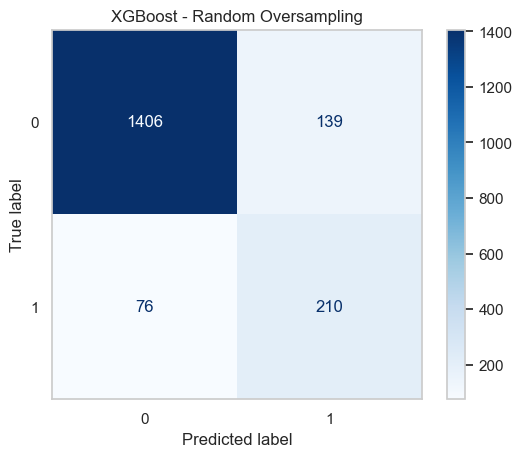

In [53]:
cm = results_xgb["XGBoost"]["Random Oversampling"]["Confusion_Matrix_Val"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)
ax.grid(False)
plt.title("XGBoost - Random Oversampling")
plt.show()

Powyżej zaprezentowano macierz pomyłek dla modelu **XGBoost** po zastosowaniu metody balansowania **Random Oversampling**. Na zbiorze walidacyjnym otrzymano następujące wyniki

- prawidłowo sklasyfikowano 1406 przypadków klasy 0 (brak zakupu) – True Negatives (TN)

- prawidłowo sklasyfikowano 210 przypadków klasy 1 (zakup) – True Positives (TP)

- 139 przypadków klasy 0 błędnie zaklasyfikowano jako 1 – False Positives (FP)

- 76 przypadków klasy 1 błędnie sklasyfikowano jako 0 – False Negatives (FN)

Macierz ta świadczy o dobrej skuteczności modelu, zwłaszcza w zakresie rozpoznawania klasy mniejszościowej (zakupu). Liczba błędnych klasyfikacji (FN = 76 i FP = 139) jest stosunkowo niska, co oznacza, że model dobrze równoważy między precyzją a czułością. Szczególnie istotne jest ograniczenie liczby FN, ponieważ w kontekście predykcji zakupów pominięcie klienta, który rzeczywiście dokona zakupu, może prowadzić do straty potencjalnego zysku.

Należy jednak zaznaczyć, że przedstawione wyniki mogą być zawyżone, ponieważ model wykazuje oznaki przeuczenia na zbiorze treningowym, co ogranicza jego zdolność do generalizacji na nowych danych.

## Feature Importance

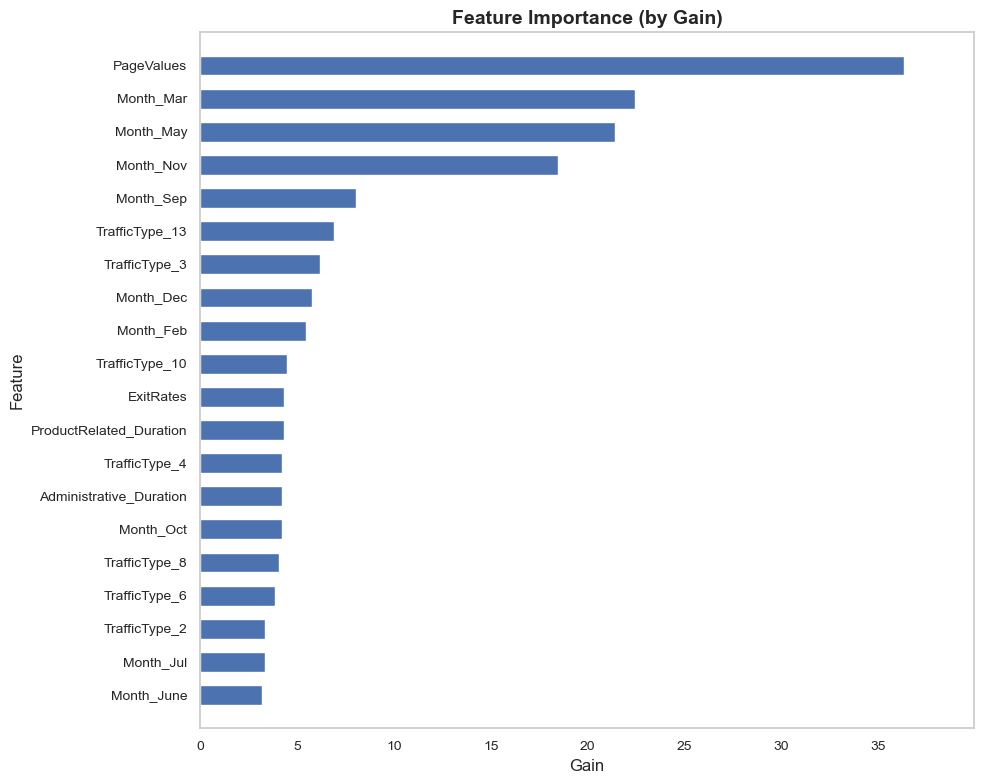

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))

plot_importance(
    trained_model,
    importance_type='gain',
    max_num_features=20,
    height=0.6,
    ax=ax,
    grid=False,
    show_values=False
)

ax.set_title("Feature Importance (by Gain)", fontsize=14, fontweight='bold')
ax.set_xlabel("Gain", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [55]:
importance = trained_model.feature_importances_
feature_names = X_train_over.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

top_features = importance_df['Feature'].head(5).tolist()

X_train_top = X_train_over[top_features].copy(deep=True)
X_val_top = X_val_final[top_features].copy(deep=True)
y_train_top = y_train_over.copy(deep=True)
y_val_top = y_val.copy(deep=True)
X_train_final_top = X_train_final[top_features].copy(deep=True)
y_train_topp = y_train.copy(deep=True)
X_test_top = X_test_final[top_features].copy(deep=True)
y_test_top = y_test.copy(deep=True)

W celu identyfikacji najbardziej istotnych zmiennych dla modelu XGBoost skorzystano z metody obliczania ważności cech opartej na wartości `Gain`. Metoda ta mierzy średni wzrost dokładności (zmniejszenie błędu) uzyskiwany przy rozdzielaniu danych według danej cechy w drzewach decyzyjnych. Wyższa wartość `Gain` oznacza większy wkład danej zmiennej w budowę modelu.

W dalszej części projektu zastosowano podejście iteracyjne, polegające na testowaniu skuteczności klasyfikatora XGBoost przy różnych liczbach wybranych cech. Metodą prób i błędów na podstawie metryk oceniono kilka wariantów od kilku do kilkunastu zmiennych. Najlepszy kompromis pomiędzy jakością predykcji a złożonością modelu uzyskano przy wyborze **5 cech o najwyższej wartości Gain**. W celu zachowania przejrzystości raportu, w kodzie uwzględniono jedynie finalny, optymalny wariant – fragmenty dotyczące pozostałych konfiguracji zostały pominięte.

Największy wpływ na klasyfikację mają cechy:

- `PageValues`
- `Month_Mar`
- `Month_May`
- `Month_Nov`
- `Month_Sep`

Tym samym przygotowano nowe zbiory treningowe, walidacyjne i testowe zawierające tylko wskazane cechy. Celem tej operacji jest redukcja wymiarowości oraz zwiększenie interpretowalności modelu przy zachowaniu wysokich wartości metryk klasyfikacyjnych.

In [56]:
model = XGBClassifier(random_state=42)
model_name = "XGBoost"

results, trained_model = train_and_evaluate_model(model, model_name, X_train_top, y_train_top, X_val_top, y_val_top)

In [57]:
metrics_only = results["XGBoost"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["XGBoost"])
df_results.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.845,0.799,0.896,0.853,0.648,0.727,0.584,0.877


Po ograniczeniu zbioru do **5 najważniejszych zmiennych** nastąpiła zauważalna **poprawa równowagi pomiędzy metrykami dla zbioru treningowego i walidacyjnego, co świadczy o zmniejszeniu przeuczenia modelu** (overfittingu).

Podczas gdy wcześniej metryki na zbiorze treningowym były znacznie wyższe niż na walidacyjnym, natomiast obecnie różnice te uległy zmniejszeniu. Na zbiorze walidacyjnym model uzyskał następujące wyniki:

- `F1-Score` = 0.648
- `Recall` = 0.727
- `Precision` = 0.584
- `Accuracy` = 0.877

Wskaźniki te są bardziej zrównoważone względem zbioru treningowego (`F1-Score` = 0.845, `Recall` = 0.799, `Precision` = 0.896, `Accuracy` = 0.853), co sugeruje, że model lepiej generalizuje na danych niewidzianych.

Dodatkowo, ograniczenie liczby cech do pięciu zmniejszyło złożoność obliczeniową modelu. W kontekście dalszego tuningu hiperparametrów oznacza to krótszy czas uczenia i mniejsze ryzyko nadmiernego dopasowania, przy zachowaniu wysokiej skuteczności predykcji.

## Optymalizacja hiperparametrów

In [58]:
pipe = Pipeline(steps=[
    ('sampler', RandomOverSampler(random_state=42)),
    ("model", XGBClassifier(
        objective="binary:logistic",
        random_state=42,
    ))
])

Powyższy pipeline składa się z dwóch kroków: najpierw zastosowano Random Oversampling, aby zbalansować klasy w zbiorze treningowym przez losowe duplikowanie obserwacji klasy mniejszościowej. Następnie wykorzystano model XGBoost z ustawieniem `binary:logistic` do klasyfikacji binarnej. Pipeline pozwala na zintegrowanie przetwarzania danych i trenowania modelu w jednym obiekcie, co ułatwia późniejszy tuning hiperparametrów z użyciem kroswalidacji.

In [59]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_alpha": [0, 0.1],
    "model__reg_lambda": [1.0, 5.0]
}

Zdefiniowana siatka param_grid zawiera zestawy hiperparametrów, które mają zostać przetestowane w procesie tuningu modelu XGBoost. Uwzględniono:

- `n_estimators`: liczba drzew w modelu (100, 200, 300)
- `learning_rate`: tempo uczenia (0.05, 0.1)
- `max_depth`: maksymalna głębokość drzewa (3, 4, 5)
- `subsample`: proporcja próbek używana do budowy każdego drzewa (0.8, 1.0)
- `colsample_bytree`: proporcja cech używana przy budowie drzewa (0.8, 1.0)
- `reg_alpha`: współczynnik regularyzacji L1 (0, 0.1)
- `reg_lambda`: współczynnik regularyzacji L2 (1.0, 5.0)

Parametry te wpływają na złożoność modelu, jego zdolność generalizacji oraz kontrolują ryzyko przeuczenia.

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_custom = make_scorer(f1_score, average="binary", zero_division=0)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=75,           
    scoring=f1_custom,   
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

Skonfigurowano proces tuningu hiperparametrów modelu XGBoost z użyciem losowego przeszukiwania (`RandomizedSearchCV`) oraz 5-krotnej kroswalidacji (`StratifiedKFold`).

- `StratifiedKFold` zapewnia podział danych na 5 części z zachowaniem proporcji klas, co pozwala na bardziej wiarygodną ocenę skuteczności modelu.
- `make_scorer(f1_score)` definiuje metrykę, według której oceniane są kombinacje hiperparametrów – w tym przypadku jest to `F1-Score`, szczególnie istotna przy niezrównoważonych klasach.
- `RandomizedSearchCV` losowo wybiera 75 kombinacji z podanej siatki parametrów (`n_iter=75`) i dla każdej z nich przeprowadza 5-krotną walidację krzyżową.
- Ustawienie `n_jobs=-1` pozwala wykorzystać wszystkie dostępne rdzenie procesora, a `verbose=1` umożliwia śledzenie postępu tuningu.

Dzięki tej konfiguracji możliwe jest znalezienie zestawu parametrów, który maksymalizuje jakość klasyfikacji przy jednoczesnym ograniczeniu czasu obliczeń.

In [61]:
search.fit(X_train_final_top, y_train_topp)

print("Najlepsze parametry:", search.best_params_)
print("Wynik CV (F1):", search.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Najlepsze parametry: {'model__subsample': 0.8, 'model__reg_lambda': 5.0, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
Wynik CV (F1): 0.6728996963246364


Wykonano dopasowanie modelu do danych treningowych z użyciem ``RandomizedSearchCV. Wybrano najlepszy zestaw hiperparametrów maksymalizujący `F1-Score` na podstawie 5-krotnej kroswalidacji. Wyniki zawierają zarówno najlepsze parametry, jak i odpowiadający im średni wynik `F1`.

In [62]:
best_model = search.best_estimator_

In [63]:
model = best_model
model_name = "XGBoost_tuned"
results = train_and_evaluate_model(model, model_name, X_train_final_top, y_train_topp, X_val_top, y_val_top)

Uzyskany najlepszy model (`best_model`) został ponownie dopasowany do danych treningowych i oceniony na zbiorze walidacyjnym. Do oceny wykorzystano funkcję `train_and_evaluate_model`, która oblicza kluczowe metryki skuteczności (m.in. F1-Score, Recall, Precision, Accuracy) osobno dla zbioru treningowego i walidacyjnego.

In [64]:
metrics_dict = results[0]
metrics_only = metrics_dict["XGBoost_tuned"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["XGBoost_tuned"])
df_results.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.680,0.800,0.591,0.882,0.670,0.780,0.587,0.880


Model XGBoost po tuningu hiperparametrów wykazał znaczącą poprawę w zakresie dopasowania do zbioru walidacyjnego. Przeuczenie modelu, obserwowane wcześniej (gdy różnice między metrykami na zbiorze treningowym i walidacyjnym były bardzo duże), zostało wyraźnie zredukowane — metryki na obu zbiorach są teraz bardziej zbliżone.

Po optymalizacji hiperparametrów model osiągnął następujące wyniki:

- `F1-Score (train)` = 0.680, `F1-Score (val)` = 0.670
- `Recall (train)` = 0.800, `Recall (val)` = 0.780
- `Precision (train)` = 0.591, `Precision (val)` = 0.587
- `Accuracy (train)` = 0.882, `Accuracy (val)` = 0.880

Warto podkreślić, że model zachował wysoką czułość (`Recall`) – istotną przy identyfikowaniu przypadków pozytywnych (np. zakupów), a jednocześnie poprawił ogólną równowagę między metrykami. Fakt, że metryki na zbiorze walidacyjnym są bardzo zbliżone do wyników na treningowym, świadczy o **lepszej generalizacji modelu**, czyli jego większej odporności na przeuczenie.

Uzyskane rezultaty potwierdzają skuteczność procesu tuningu – dopasowany model XGBoost dobrze radzi sobie z klasyfikacją, zachowując przy tym odpowiedni balans między precyzją a czułością.

## Interakcje

In [65]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_train_final_top)

poly_features = poly.get_feature_names_out(X_train_final_top.columns)

X_train_poly = pd.DataFrame(X_poly, columns=poly_features, index=X_train_final_top.index)
X_val_poly = pd.DataFrame(poly.transform(X_val_top), columns=poly_features, index=X_val_top.index)

W celu sprawdzenia, czy uwzględnienie nieliniowych zależności między zmiennymi może poprawić skuteczność modelu, zastosowano automatyczne generowanie interakcji drugiego stopnia z wykorzystaniem klasy `PolynomialFeatures`. Użyto opcji `degree=2` oraz `interaction_only=False`, co oznacza, że wygenerowane zostały zarówno interakcje między zmiennymi, jak i ich kwadraty.

Nowym cechom (interakcje i potęgi) nadano odpowiednie nazwy i przeniesiono do ramki danych, a następnie zbudowano zbiór walidacyjny w analogiczny sposób.

In [66]:
model = best_model
model_name = "XGBoost_tuned"
results = train_and_evaluate_model(model, model_name, X_train_poly, y_train_topp, X_val_poly, y_val_top)

Model XGBoost po tuningu został ponownie wytrenowany, tym razem z nowym rozszerzonym zbiorem treningowym zawierającym interakcje:

In [67]:
metrics_dict = results[0]
metrics_only = metrics_dict["XGBoost_tuned"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
df_results = pd.DataFrame([metrics_only], index=["XGBoost_tuned"])
df_results.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.684,0.804,0.595,0.884,0.665,0.773,0.583,0.878


Pomimo zwiększenia liczby cech poprzez wprowadzenie interakcji drugiego stopnia, **nie zaobserwowano poprawy skuteczności modelu**. Metryki na zbiorze walidacyjnym uległy jedynie nieznacznym zmianom w porównaniu do modelu bez interakcji – w niektórych przypadkach nawet nieco się pogorszyły (np. spadek precyzji i F1-score).

Ponadto, wprowadzenie dodatkowych zmiennych zwiększa złożoność obliczeniową modelu, co może prowadzić do dłuższego czasu trenowania i większego ryzyka przeuczenia przy dalszym tuningu.

Podsumowując, testowanie interakcji nie przyniosło istotnych korzyści – najlepsze wyniki nadal osiągane są dla pięciu wybranych cech bez dodatkowych kombinacji.

## Optymalizacja progu klasyfikacji

In [68]:
y_proba = best_model.predict_proba(X_train_final_top)[:, 1]

best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.1, 0.9, 0.01):
    y_pred_thresh = (y_proba >= t).astype(int)
    score = f1_score(y_train_topp, y_pred_thresh, average="binary", zero_division=0)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"Najlepszy próg: {best_thresh:.2f}, F1: {best_f1:.4f}")

Najlepszy próg: 0.79, F1: 0.7010


Domyślnie modele klasyfikacyjne, takie jak XGBoost, stosują próg 0.5 do przypisywania klas na podstawie prawdopodobieństw. W praktyce jednak zmiana tego progu może poprawić działanie modelu, szczególnie jeśli zależy nam na maksymalizacji konkretnej metryki – w tym przypadku F1-Score, który uwzględnia kompromis między precyzją a czułością.

Zmiana domyślnego progu klasyfikacji może znacząco wpłynąć na jakość predykcji, szczególnie w nierównomiernie rozłożonych klasach.

In [69]:
y_pred_train = (best_model.predict_proba(X_train_final_top)[:, 1] >= best_thresh).astype(int)
y_pred = (best_model.predict_proba(X_val_top)[:, 1] >= best_thresh).astype(int)

results = {
            "F1-Score_Train": f1_score(y_train_topp, y_pred_train, average="binary", zero_division=0),
            "Recall_Train": recall_score(y_train_topp, y_pred_train, average="binary", zero_division=0),
            "Precision_Train": precision_score(y_train_topp, y_pred_train, average="binary", zero_division=0),
            "Accuracy_Train": accuracy_score(y_train_topp, y_pred_train),

            "F1-Score_Val": f1_score(y_val_top, y_pred, average="binary", zero_division=0),
            "Recall_Val": recall_score(y_val_top, y_pred, average="binary", zero_division=0),
            "Precision_Val": precision_score(y_val_top, y_pred, average="binary", zero_division=0),
            "Accuracy_Val": accuracy_score(y_val_top, y_pred)
}

df = pd.DataFrame([results])
df.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Val,Recall_Val,Precision_Val,Accuracy_Val
0.701,0.723,0.680,0.904,0.655,0.675,0.637,0.889


Na podstawie przedstawionych wyników można zauważyć, że po zastosowaniu niestandardowego progu klasyfikacji (0.79), metryki modelu XGBoost uległy pogorszeniu – szczególnie na zbiorze walidacyjnym.

Metryki po optymalizacji progu:

- `F1-Score_Val`: spadek z 0.670 do 0.655
- `Recall_Val`: spadek z 0.780 do 0.675
- `Precision_Val`: wzrost z 0.587 do 0.637
- `Accuracy_Val`: wzrost z 0.880 do 0.889

Chociaż precyzja (`Precision`) na zbiorze walidacyjnym nieznacznie wzrosła (z 0.587 do 0.637), to czułość (`Recall`) istotnie spadła (z 0.780 do 0.675), co spowodowało delikatne obniżenie ogólnej wartości `F1-Score`. Oznacza to, że model po zmianie progu lepiej unika fałszywych alarmów (FP), ale częściej pomija rzeczywistą klasę pozytywną (FN).

## Ewaluacja najlepszego modelu na zbiorze testowym

In [70]:
model = best_model
model_name = "XGBoost_tuned"
results = train_and_evaluate_model(model, model_name, X_train_final_top, y_train_topp, X_test_top, y_test_top)

In [71]:
metrics_dict = results[0]
metrics_only = metrics_dict["XGBoost_tuned"].copy()
metrics_only.pop("Confusion_Matrix_Val", None)
metrics_only_renamed = {
    key.replace('_Val', '_Test'): value
    for key, value in metrics_only.items()
}
df_results = pd.DataFrame([metrics_only_renamed], index=["XGBoost_tuned"])
df_results.style.apply(
    lambda row: ['background-color: #dff0d8; font-weight: bold'] * len(row),
    axis=1
).format(precision=3).hide(axis="index")

F1-Score_Train,Recall_Train,Precision_Train,Accuracy_Train,F1-Score_Test,Recall_Test,Precision_Test,Accuracy_Test
0.680,0.800,0.591,0.882,0.680,0.794,0.594,0.883


Na zakończenie przeprowadzono ocenę jakości działania najlepszego modelu (`XGBoost_tuned`) na niezależnym zbiorze testowym. Uzyskane wyniki przedstawiają się następująco:

- `F1-Score` = 0.680  
- `Recall (czułość)` = 0.794  
- `Precision (precyzja)` = 0.594  
- `Accuracy (dokładność)` = 0.883

Warto zauważyć, że metryki uzyskane na zbiorze testowym są bardzo zbliżone do wyników walidacyjnych, co potwierdza dobrą zdolność modelu do generalizacji i brak przeuczenia. Szczególnie istotne jest utrzymanie wysokiej wartości czułości, co oznacza skuteczne wykrywanie przypadków klasy mniejszościowej (np. sesji zakończonych zakupem). Jednocześnie model zachowuje rozsądną precyzję, minimalizując liczbę fałszywych alarmów.

Ostatecznie można uznać, że wytrenowany model XGBoost o dostrojonych hiperparametrach i z odpowiednio dobranym zestawem cech dobrze radzi sobie z predykcją również na danych nieuczestniczących w procesie trenowania ani walidacji.

## Macierz pomyłek – zbiór testowy

Na poniższym wykresie przedstawiono macierz pomyłek dla najlepszego modelu (XGBoost po tuningu) zastosowanego na niezależnym zbiorze testowym.


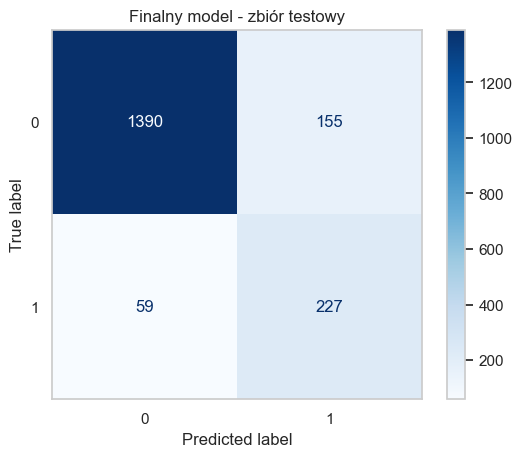

In [72]:
cm = results[0]["XGBoost_tuned"]["Confusion_Matrix_Val"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)
ax.grid(False)
plt.title("Finalny model - zbiór testowy")
plt.show()

Interpretacja:

- **True Negatives (TN = 1390)** – przypadki bez zakupu prawidłowo zaklasyfikowane jako brak zakupu.
- **False Positives (FP = 155)** – przypadki bez zakupu błędnie zaklasyfikowane jako zakup.
- **True Positives (TP = 227)** – przypadki zakupu poprawnie rozpoznane jako zakup.
- **False Negatives (FN = 59)** – przypadki zakupu błędnie sklasyfikowane jako brak zakupu.

Macierz potwierdza dobre właściwości klasyfikacyjne modelu. Model skutecznie identyfikuje przypadki zakupowe (klasa 1), przy zachowaniu akceptowalnego poziomu błędów typu FP i FN. Szczególnie istotna jest stosunkowo niska liczba **False Negatives**, co oznacza, że model rzadko pomija użytkowników, którzy faktycznie dokonali zakupu – a to kluczowe w kontekście prognozowania zachowań zakupowych.

## Eksport modelu

In [73]:
joblib.dump(best_model, "best_model_xgboost.pkl")

['best_model_xgboost.pkl']

Najlepszy wytrenowany model został zapisany do pliku `best_model_xgboost.pkl`. Dzięki temu można go w łatwy sposób załadować w przyszłości i wykorzystać do predykcji nowych danych, bez konieczności ponownego trenowania.

## Podsumowanie i wnioski

Celem projektu była budowa modelu klasyfikacyjnego w celu znalezienia najlepszego rozwiązania do **przewidywania, czy sesja użytkownika zakończy się zakupem**. Przeprowadzono kompleksowy proces przygotowania danych, balansowania klas, selekcji cech, trenowania wielu modeli, a także optymalizacji ich parametrów.

W toku eksperymentów przetestowano wiele algorytmów klasyfikacyjnych, w tym Random Forest, CatBoost, XGBoost, regresję logistyczną, SVM, Naive Bayes oraz MLPClassifier. Dla każdego modelu oceniano skuteczność przy różnych metodach balansowania danych: SMOTE, ADASYN, Random Oversampling, Random Undersampling oraz bez balansowania. Następnie wybrano najlepsze kombinacje model–balansowanie na podstawie metryk walidacyjnych.

Za najbardziej skuteczny i stabilny uznano model **XGBoost**, wykorzystujący **pięć najistotniejszych cech** wybranych na podstawie gain-based feature importance, a następnie dostrojony za pomocą **tuningowania hiperparametrów**. Model ten charakteryzował się dobrą ogólną jakością predykcji, wysoką stabilnością oraz brakiem przeuczenia.

Metryki na zbiorze treningowym i testowym:

| Metryka              | Train | Test |
|------------------|-------|------|
| **F1-Score**      | 0.680 | 0.680 |
| **Recall**           | 0.800 | 0.794 |
| **Precision**      | 0.591 | 0.594 |
| **Accuracy**      | 0.882 | 0.883 |

Wyniki te potwierdzają, że model dobrze **generalizuje** – radzi sobie z danymi, których nie widział podczas treningu. Niewielkie różnice między zbiorami treningowym i testowym sugerują brak przeuczenia. Choć precyzja (Precision) nie jest bardzo wysoka, model skutecznie wykrywa przypadki zakupu (Recall = 0.794), co w kontekście zastosowania (np. marketingowego targetowania użytkowników) może mieć istotne znaczenie – lepiej „trafnie podejrzewać” zakup, nawet kosztem części błędnych wskazań.

**Ostateczne wnioski**:

- Zastosowanie odpowiedniego **balansowania klas** (Random Oversampling) oraz selekcji cech znacząco poprawiło stabilność modelu.
- Dzięki **tuningowi hiperparametrów**, udało się **zredukować przeuczenie** (różnica metryk między train i test jest niewielka).
- Choć uzyskane metryki nie są idealne, model osiąga dobry kompromis między precyzją a czułością i wykazuje solidną skuteczność w klasyfikowaniu użytkowników dokonujących transakcji.
- Finalny model może zostać wykorzystany jako podstawa do dalszego wdrożenia lub jako punkt wyjścia do kolejnych ulepszeń (np. eksploracji cech nieliniowych, analizy sekwencji odwiedzin czy zastosowania modeli głębokich).

Projekt pokazuje, że nawet przy ograniczonych danych wejściowych, właściwa inżynieria cech, balansowanie klas i tuning mogą prowadzić do stworzenia solidnego modelu predykcyjnego.